# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [3]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # or: from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns #Seaborn is a Python visualization library based on matplotlib.
#It provides a high-level interface for drawing attractive statistical graphics.

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185

##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

**Answer: **

PCA: PCA finds vectors that explains the variance of the data. Variance is always non-negative: a small variance indicates that the data points tend to be very close to the mean (expected value) and hence to each other, while a high variance indicates that the data points are very spread out around the mean and from each other. [Variance definition](https://en.wikipedia.org/wiki/Variance). In this case we can expect the first PCA dimension to be products that differ from the rest in quantity, that require daily delivery like Fresh Food, Milk and Grocery.

* In the PCA plot we can observe the cumulative "Variance Ratio of Individual Components".

ICA: ICA finds basis vectors that are statistically independent of the projected data. We can expect to receive a matrix containing all the features (six).

* These statistically independent vectors are the six rows of the ICA heatmap shown below. Each row represents one ICA component. For example, the first ICA component could be strongly correlated or anti-correlated with three of the original features. The independent component increases with increasing "feature #3" scores (Grocery) and decreases with "features #2 and #5" (Milk and Detergents_Paper). This suggests that these three criteria vary together. If one increases, then one increases and the remaining two decrease.

###PCA

In [14]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
#PCA finds vectors that explains the variance of the data
pca = PCA(n_components = 6).fit(data)

# Print the components and the amount of variance in the data contained in each dimension
# Components of the data
print pd.DataFrame(pca.components_, columns = list(data.columns))
# Variance of the data
print "------------------------------------------"
print "Variance Ratio of Individual Components"
print "------------------------------------------"
print list(data.columns) #Columns names
print pca.explained_variance_ratio_

Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0 -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
1 -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
2 -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
3 -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
4  0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077
5 -0.015763  0.033492  0.410939 -0.013289         -0.871284     -0.265417
------------------------------------------
Variance Ratio of Individual Components
------------------------------------------
['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]

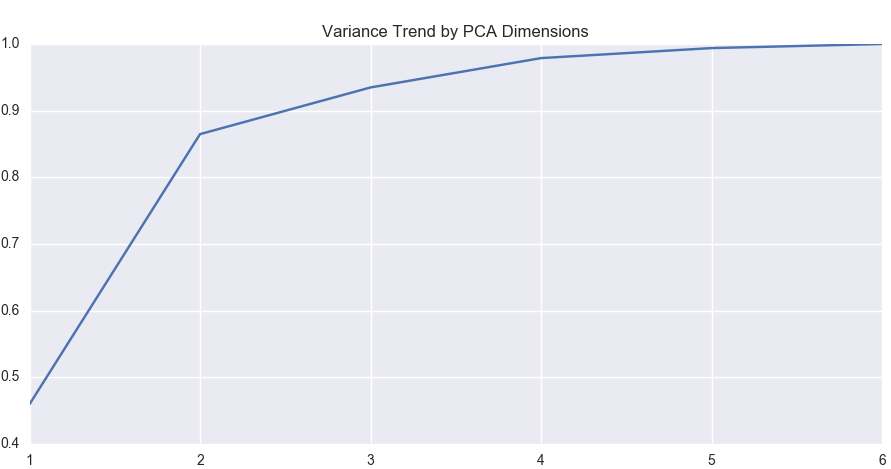

In [29]:
# plot the Variance Trend by PCA Dimensions graph
plt.figure(figsize=(11,5))
plt.title("Variance Trend by PCA Dimensions")
plt.plot(np.arange(1,7),np.cumsum(pca.explained_variance_ratio_))
plt.legend()
plt.savefig("VarianceTrendbyPCADimensions.png")
plt.xlabel("number of pca components")
plt.ylabel("cumulative variance explained by each dimension")
plt.show()

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

**Answer: **

PCA emphasises on gaining more information and minimizing loss of the same. As seen from the PCA graph most of the variance in the dataset is explained by the first two principal components. After two dimensions the graph begins to flatten. To explain the variability of the dataset it would be more appropriate to use 2 dimensions.

**3)** What do the dimensions seem to represent? How can you use this information?

**Answer: **

PCA provides dimensionality reduction for visualisation of data and makes it possible to identify latent features and make proper use of the data without increasing computational cost. The dimensions represent eigen vectors. 

Making use of the information from the previous graph we observe that the first two principal components and recalling that PCA first converges to the center of the dataset and projects its axes along the spread of the data, the first two principal components explain about 85% of the variability in the dataset. 

Using these two features in the training of the PCA algorithm we can have a maximum coverage of the dataset's variability without losing a lot of information.

**Interpreting the numerical vectors returned to us from PCA**

*Note: For simplicity purposes, only the first two vectors will be mentioned* (Refer to the **code above**, In[14] and Out[14])

* The **first vector** represents the **1st principal component (PCA1)**:

          Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen

      0 -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105


It increases with only one of the values, decreasing the purchase of Fresh products. This component can be viewed as a measure of small and large stores choosing to reduce their consumption of fresh products from our store.

* The **first vector** represents the **2nd principal component (PCA2)**:

          Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen

      1 -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079


It increases with increasing the consumption of Milk and Grocery products. This component can be viewed as a measure of small and large stores choosing to increase their consumption of Milk and Grocery products from our store. This suggests that when the consumption of Milk increases more Grocery products will be sold.

###ICA

In [39]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
#centered_data = data.copy() - data.mean() #centering data at the origin
#using ICA
#ica = FastICA(n_components = 6).fit(centered_data)
#print "Output from ica_model: "
#print ica
#print "ICA components: " 
# Print the independent components
# Components of the data
#print pd.DataFrame(ica.components_, columns = list(data.columns))

#To make the numbers more interpretable, I performed a unit variance to the centered data
centered_data = data.copy() - data.mean() #centering data at the origin
#Added after the review Change in code #2
#centered_data /= centered_data.std()
unit_variance = centered_data / centered_data.std()
#using ICA
ica = FastICA(n_components = 6).fit(unit_variance)
print "Output from ica_model: "
print ica
print "ICA components: " 
# Print the independent components
# Components of the data
print pd.DataFrame(ica.components_, columns = list(data.columns))

Output from ica_model: 
FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=6, random_state=None, tol=0.0001, w_init=None,
    whiten=True)
ICA components: 
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0  0.003808 -0.016937 -0.114908  0.007092          0.134513      0.016171
1  0.004887  0.001620  0.005717  0.002535         -0.002436     -0.051024
2 -0.050283  0.006331  0.005868  0.003292         -0.009757      0.002953
3  0.010943  0.001035 -0.007359 -0.054111          0.002653      0.016787
4  0.002673 -0.013982  0.060533  0.002031         -0.003227     -0.004025
5  0.001940  0.072672 -0.055176 -0.001770          0.015753     -0.017088

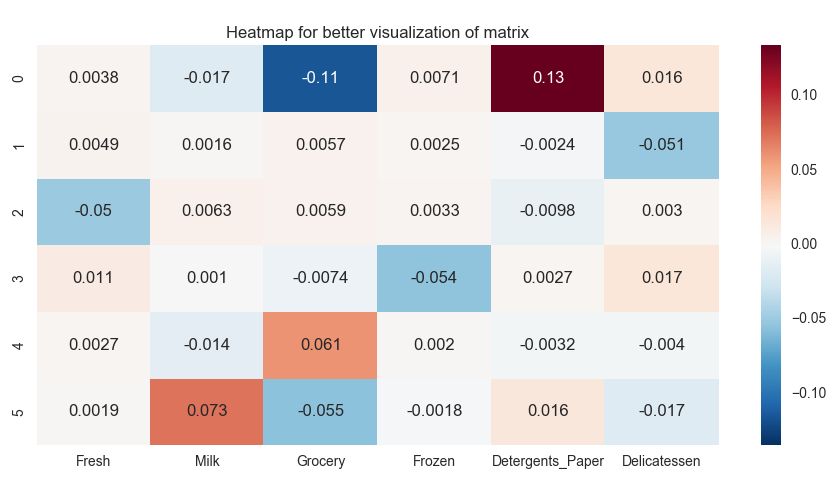

In [51]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
# import seaborn as sns #Seaborn is a Python visualization library based on matplotlib.
# Seaborn provides a high-level interface for drawing attractive statistical graphics.

#plotting heat map for better visualization of matrix
#heatmap = plt.pcolor(data) #produces a table of the data but instead of values there are colors
plt.figure(figsize = (11,5))
plt.title("Heatmap for better visualization of matrix")
sns.heatmap(pd.DataFrame(ica.components_, columns = list(data.columns)),annot = True)
plt.legend()
plt.savefig("HeatmapToVisualizeMatrix.png")
plt.xlabel("independent components (ica values)")
plt.ylabel("number of ica independent components")
plt.show()

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

**Answer: **

ICA: Independent Component Analysis attempts to decompose a multivariate signal into independent non-gaussian signals. It is primarily used in signal processing.

It gives us a basis by which we can separate indepenedent features. This is essential for making use of the clustering method; this helps us to have more visible boundaries to separate the customer segment.

These components can be interpreted as the absolute value of the elements of the unmixing matrix increases; the corresponding feature has a strong effect on that component. Therefore the magnitude of the coefficient represents prevalence in that feature.

But we also need to take into account for the positive and negative sign of the coefficient as they are considered anti-correlated to each other. Meaning that if we have a high positive coefficient and a very negative coefficient, it would be interpreted as one or another but not both, hence anti-associated to each other.

For example a dimension with a large positive value for fresh and negative value for frozen would suggest that, independent of other effects, there is an anti-correlation between fresh and frozen purchases. Thus this could come from a distinction between something like a farmers market and frozen food store which might have some frozen but far more fresh produce.

**TODO: Fit an ICA model to the data**

Note: Adjust the data to have center at the origin first!

    centered_data = data.copy() - data.mean() #centering data at the origin

    ica = ica_model(centered_data, 6) #previous code for ICA model

**To make the numbers more interpretable, I performed a unit variance to the centered data**


TODO: Fit an ICA model to the data

Note: Adjust the data to have center at the origin first!

    centered_data = data.copy() - data.mean() #centering data at the origin

    unit_variance = centered_data / centered_data.std() #unit variance of the centered data

    ica = ica_model(unit_variance, 6) #code to make ICA output more interpretable

**Interpreting the numerical vectors returned to us from ICA**

*Note: For simplicity purposes, only the first two vectors will be mentioned* (Refer to the **code above**, In[39] and Out[39])

* The **first vector** represents the **1st independent component (ICA1)**:

          Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen

      0  0.003808 -0.016937 -0.114908  0.007092          0.134513      0.016171


It increases with decreasing the consumption of Groceries and increasing the consumption of Detergents_Paper. When this component increases (time delivery) there will be stores (perhaps the small and medium size stores-not large stores) consuming less Grocery products but more Detergent_Papers from us.


* The **second vector** represents the **2nd independent component (ICA2)**:

           Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen

      1  0.004887  0.001620  0.005717  0.002535         -0.002436     -0.051024


It increases with only one of the values, decreasing the purchase of Delicatessen products. When this component increases (time delivery) there will be stores (perhaps the small stores-usually the main consumers of fine products) choosing to reduce their consumption of Delicatessen products from us.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

**Answer: **

The k-means method is used to divide the observations into homogeneous clusters, based on their description by a set of quantitative variables.

Advantages of K-means clustering:

1. Fast, robust and easier to understand.

2. Relatively efficient: O(tknd), where n is # objects, k is # clusters, d is # dimension of each object, and t  is # iterations. Normally, k, t, d << n.

3. Gives best result when data set are distinct or well separated from each other.

4. By multiplying the starting points and the repetitions, several solutions may be explored.

 [KmeansClustering-Source1](https://sites.google.com/site/dataclusteringalgorithms/k-means-clustering-algorithm)

 [KmeansClustering-Source2](https://www.xlstat.com/en/solutions/features/k-means-clustering)


Advantages of Gaussian Mixture Models::

1. Fastest algorithm for learning mixture model 

2. Gives extremely useful result for the real world data set.

3. As this algorithm maximizes only the likelihood, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.

4. The GMM algorithm is a good algorithm to use for the classification of static postures and non-temporal pattern recognition.

 [GMMClustering-Source1](https://sites.google.com/site/dataclusteringalgorithms/gaussian-clustering-algorithm)

 [GMMClustering-Source2](http://www.nickgillian.com/wiki/pmwiki.php/GRT/GMMClassifier)

 [GMMClustering-Source3](http://scikit-learn.org/stable/modules/mixture.html)

Basically **K-means** is the **hard clustering Mixture of Gaussian**.

A **major motivation for using k-means** is its simplicity and scalability, whereas Bayesian models require sampling algorithms or variational inference techniques which can be difficult to implement and are often not scalable, k-means is straightforward to implement and works well for a variety of applications.

The **connection between k-means and mixtures of Gaussians** is namely that the k-means algorithm may be viewed as a limit of the expectation-maximization (EM) algorithm—If all of the covariance matrices corresponding to the clusters in a Gaussian mixture model are equal to  σ I and we let  σ  go to zero, the EM steps approach the k-means steps in the limit. [EM details](http://arxiv.org/pdf/1111.0352.pdf).

In terms of **speed/scalability**, **GMM is similar to K-means**, but slower because it performs **soft clustering** (more **refined** clusters).

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [11]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [135]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components = 2).fit_transform(centered_data)
print pd.DataFrame(reduced_data[:10], columns = ["1st-dimension (x)", "2nd-dimension (y)"])
#print len(reduced_data) # it's equivalent to the number of samples in the .csv file, 440

   1st-dimension (x)  2nd-dimension (y)
0        -650.022122        1585.519090
1        4426.804979        4042.451509
2        4841.998707        2578.762176
3        -990.346437       -6279.805997
4      -10657.998731       -2159.725815
5        2765.961593        -959.870727
6         715.550892       -2013.002266
7        4474.583667        1429.496972
8        6712.095397       -2205.909156
9        4823.634354       13480.559205

In [139]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#Adjust 3 or 4 or k clusters
clustersKMeans = KMeans(n_clusters = 2).fit(reduced_data)
#Adjust 2 or 3 or 4  or k clusters
clustersGMM = GMM(n_components = 2).fit(reduced_data)
print "Here is the clustersKMeans (code): " + str(clustersKMeans)
print "---------"
print "Here is the clustersGMM (code): " + str(clustersGMM)

Here is the clustersKMeans (code): KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)
----------------
Here is the clustersGMM (code): GMM(covariance_type='diag', init_params='wmc', min_covar=0.001, n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None, thresh=None, tol=0.001, verbose=0)

In [149]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_KMeans = clustersKMeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z_GMM = clustersGMM.predict(np.c_[xx.ravel(), yy.ravel()])

In [161]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroidsKMeans = clustersKMeans.cluster_centers_
centroidsGMM = clustersGMM.means_
print "centroids of clustersKMeans: "
print pd.DataFrame(centroidsKMeans, columns = ["x-axis", "y-axis"])
print "---------------"
print "cluster means of clustersGMM: "
print pd.DataFrame(centroidsGMM, columns = ["x-axis", "y-axis"])

x-axis        y-axis
0 -24088.332767  1218.179383
1   4175.311013  -211.151093
---------------
cluster means of clustersGMM: 
x-axis       y-axis
0 -10810.230089  9858.155324
1   3308.393018 -3017.017397

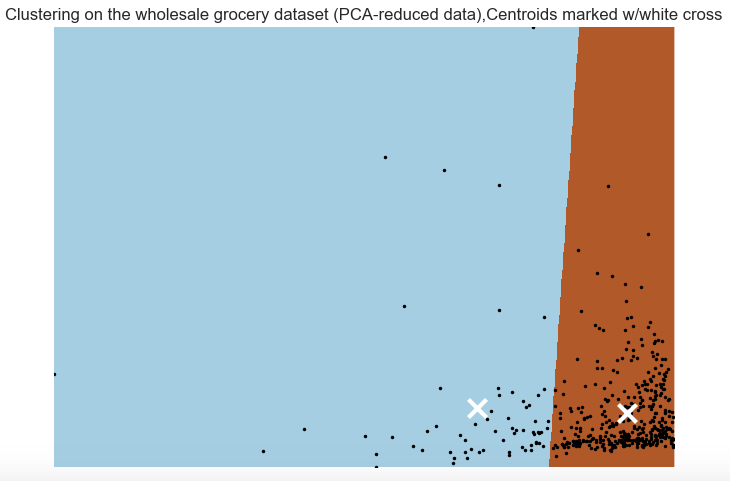

In [68]:
# Put the result into a color plot

#Z_KMeans model plot
Z_KMeans = Z_KMeans.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_KMeans, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

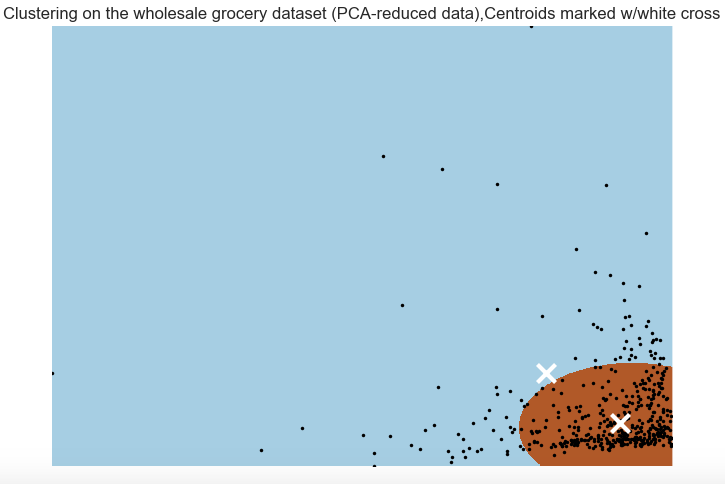

In [90]:
# Put the result into a color plot

#Z_GMM model plot
Z_GMM = Z_GMM.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_GMM, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

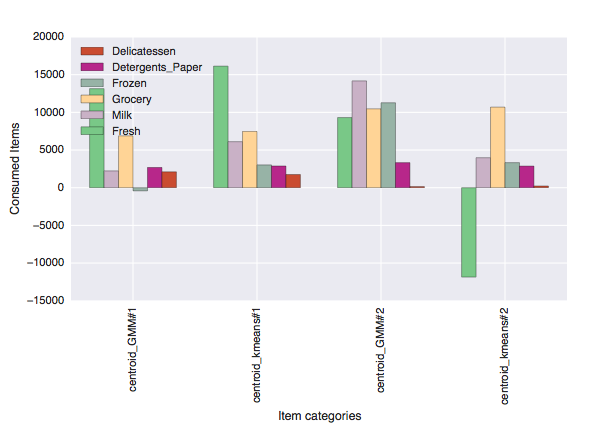

In [344]:
#This multiple Barchart belongs to Kmeans and GMM models with 2 clusters
#Bar chart demo with pairs of bars grouped for easy comparison
#print "-----------------------------------------------------"
#print "Bar chart of the centroids in the original dimensions"

#argument of all_barcharts function
items = list(data.columns)
#print "items:"
#print items
# items:
# ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

#one simple function to print barcharts of Kmeans clusters and GMM clusters with multiple k values
all_barcharts(pca, centered_data, clusters, items) #refer to Line 355 from customer_segments.py
#print "-----------------------------------------------------"

**Other models:** KMeans(n_clusters = 3, 4, k) and GMM(n_components = 3, 4, k)

Here is the clustersKMeans (code): KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)
----------------
centroids of clustersKMeans: 
         x-axis        y-axis
0   4165.121782  -3105.158115
1 -23978.865666  -4445.566118
2   1341.311246  25261.391897

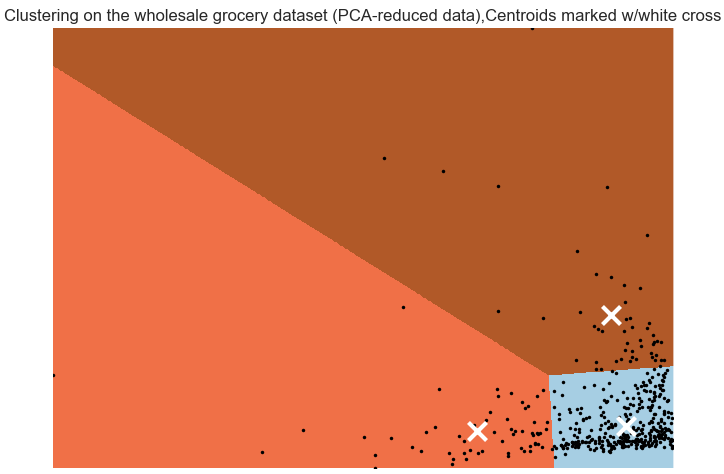

In [146]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#Adjust 3 or 4 or k clusters
clustersKMeans = KMeans(n_clusters = 3).fit(reduced_data)
print "Here is the clustersKMeans (code): " + str(clustersKMeans)
print "---------"
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_KMeans = clustersKMeans.predict(np.c_[xx.ravel(), yy.ravel()])
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroidsKMeans = clustersKMeans.cluster_centers_
print "centroids of clustersKMeans: "
print pd.DataFrame(centroidsKMeans, columns = ["x-axis", "y-axis"])
print "---------------"
# Put the result into a color plot

#Z_KMeans model plot
Z_KMeans = Z_KMeans.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_KMeans, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Here is the clustersGMM (code): GMM(covariance_type='diag', init_params='wmc', min_covar=0.001, n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None, thresh=None, tol=0.001, verbose=0)
----------------
cluster means of clustersGMM:: 
         x-axis        y-axis
0   7007.454277   4294.013607
1 -17858.653673  10050.339302
2    313.485394  -6497.205211

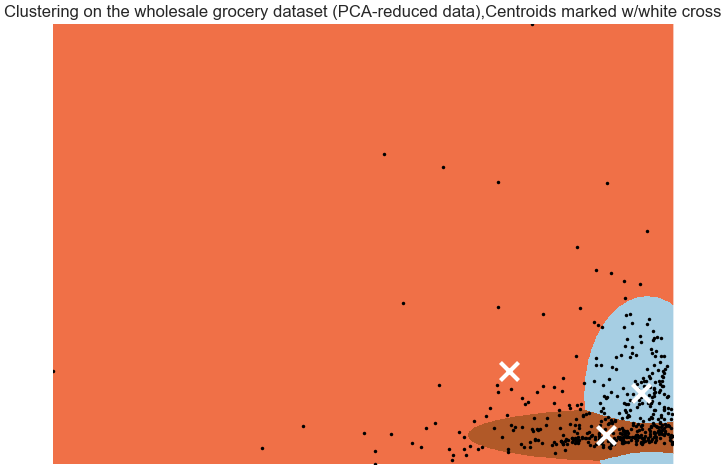

In [147]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#Adjust 2 or 3 or 4  or k clusters
clustersGMM = GMM(n_components = 3).fit(reduced_data)
print "Here is the clustersGMM (code): " + str(clustersGMM)
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_GMM = clustersGMM.predict(np.c_[xx.ravel(), yy.ravel()])
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroidsGMM = clustersGMM.means_
print "cluster means of clustersGMM: "
print pd.DataFrame(centroidsGMM, columns = ["x-axis", "y-axis"])
print "---------------"
# Put the result into a color plot

#Z_GMM model plot
Z_GMM = Z_GMM.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_GMM, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

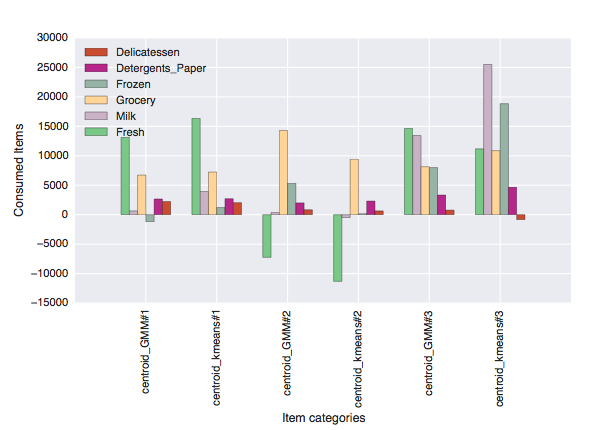

In [344]:
#This multiple Barchart belongs to Kmeans and GMM models with 3 clusters
#Bar chart demo with pairs of bars grouped for easy comparison
#print "-----------------------------------------------------"
#print "Bar chart of the centroids in the original dimensions"

#argument of all_barcharts function
items = list(data.columns)
#print "items:"
#print items
# items:
# ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

#one simple function to print barcharts of Kmeans clusters and GMM clusters with multiple k values
all_barcharts(pca, centered_data, clusters, items) #refer to Line 355 from customer_segments.py
#print "-----------------------------------------------------"

Here is the clustersKMeans (code): KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)
----------------
centroids of clustersKMeans: 
         x-axis        y-axis
0 -24220.711883  -4364.455600
1   5710.989650  12661.456873
2   3542.086052  -4936.721213
3 -14537.717744  61715.670852

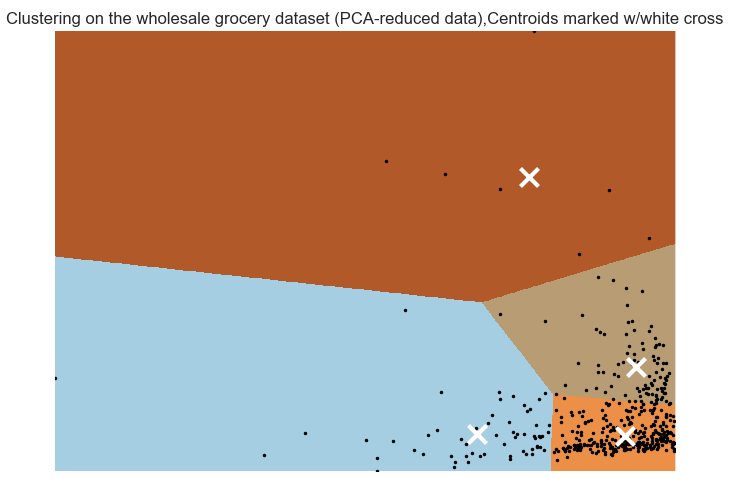

In [146]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#Adjust 3 or 4 or k clusters
clustersKMeans = KMeans(n_clusters = 4).fit(reduced_data)
print "Here is the clustersKMeans (code): " + str(clustersKMeans)
print "---------"
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_KMeans = clustersKMeans.predict(np.c_[xx.ravel(), yy.ravel()])
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroidsKMeans = clustersKMeans.cluster_centers_
print "centroids of clustersKMeans: "
print pd.DataFrame(centroidsKMeans, columns = ["x-axis", "y-axis"])
print "---------------"
# Put the result into a color plot

#Z_KMeans model plot
Z_KMeans = Z_KMeans.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_KMeans, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Here is the clustersGMM (code): GMM(covariance_type='diag', init_params='wmc', min_covar=0.001, n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None, thresh=None, tol=0.001, verbose=0)
----------------
cluster means of clustersGMM:: 
         x-axis        y-axis
0 -15372.371943  -3334.433799
1   7174.547193   5469.028765
2   2339.152042  -6708.930657
3  -9486.974257  34645.204282

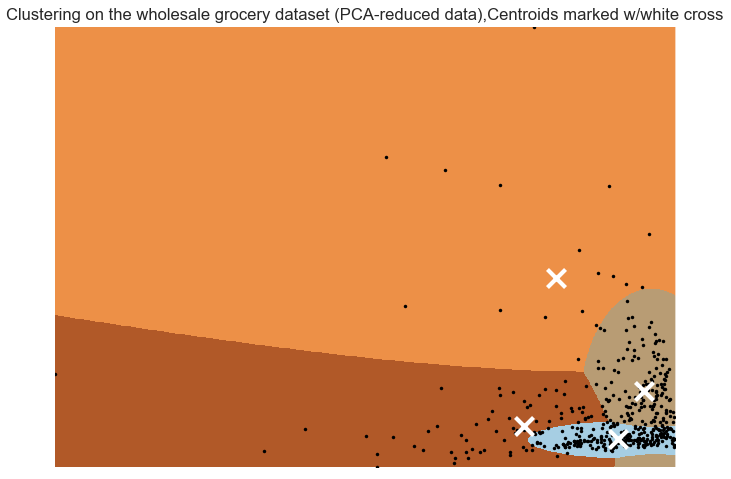

In [147]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#Adjust 2 or 3 or 4  or k clusters
clustersGMM = GMM(n_components = 4).fit(reduced_data)
print "Here is the clustersGMM (code): " + str(clustersGMM)
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_GMM = clustersGMM.predict(np.c_[xx.ravel(), yy.ravel()])
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroidsGMM = clustersGMM.means_
print "cluster means of clustersGMM: "
print pd.DataFrame(centroidsGMM, columns = ["x-axis", "y-axis"])
print "---------------"
# Put the result into a color plot

#Z_GMM model plot
Z_GMM = Z_GMM.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_GMM, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

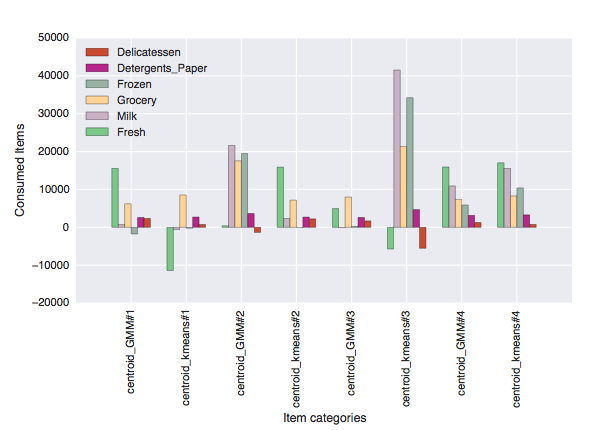

In [344]:
#This multiple Barchart shown belongs to Kmeans and GMM models with 4 clusters
#Bar chart demo with pairs of bars grouped for easy comparison
#print "-----------------------------------------------------"
#print "Bar chart of the centroids in the original dimensions"

#argument of all_barcharts function
items = list(data.columns)
#print "items:"
#print items
# items:
# ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

#one simple function to print barcharts of Kmeans clusters and GMM clusters with multiple k values
all_barcharts(pca, centered_data, clusters, items) #refer to Line 355 from customer_segments.py
#print "-----------------------------------------------------"

**7)** What are the central objects in each cluster? Describe them as customers.

**Answer: **

In the plot that refers the GMM model with 2 clusters, one cluster is formed by the group of close points at the bottom right of the graph. The other cluster is formed by all the points that are not within the first cluster. Given that the wholesale store distributes primarily to two different kind of customers, large volume customer and small family run shops, we can interpret these two clusters as the two type of wholesale customers. Since, there was a large number complains received from small family run shops (after the wholesale store began delivering food products every evening), we can clearly see that the bottom right cluster represents the small family run shops wheareas the rest of the points (mostly located in the middle or at the top) represents the large volume customers.

We can observe the details in the multiple Barchart that refers the GMM model with 2 clusters. The GMM centroid that shows a negative value in consumption of Fresh products represents the cluster that locates at the bottom of the GMM plot with 2 clusters, the small store customers who complain after the change in the delivery schedule. The other GMM centroid stands for the medium and large store customers

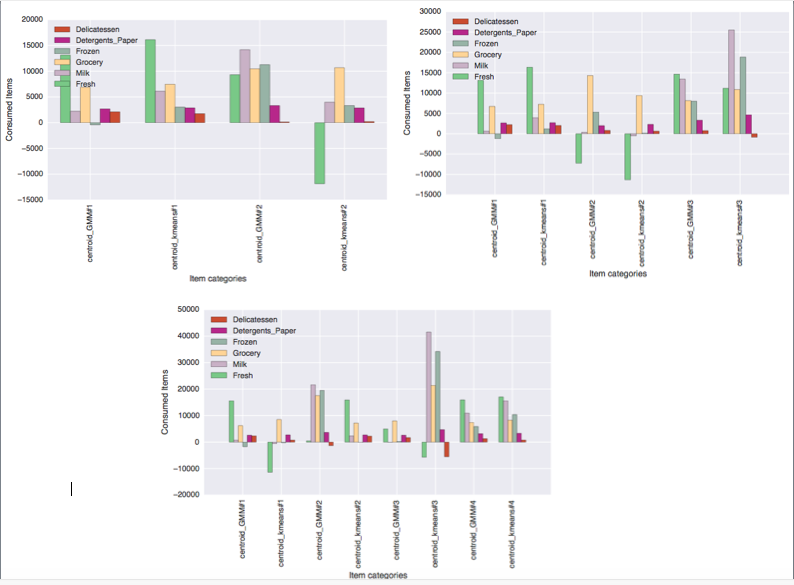

In [344]:
#These multiple Barcharts shown belongs to Kmeans and GMM models with 2, 3 and 4 clusters
#Bar chart demo with pairs of bars grouped for easy comparison
#Bar chart of the centroids in the original dimensions 
#refer to Line 355 from customer_segments.py

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

**Answer: **

PCA along with GMM gave most insight into the data. PCA helped to develop latent features and also reduced dimensions for better visualization of data. In this case it reduced the feature space to 2 to better visualize the data (two clusters). Then, GMM provided better results from K-means by incorporating EM (expectation-maximization algorithm) for fitting of Gaussian-Mixture Models (GMM). This is truly useful when there is no clear division of data. Grouping the data into clusters implementing GMM enables us to separate the customers into their respective market segments facilitating business decision making.

**9)** How would you use that technique to help the company design new experiments?

**Answer: **

Since we now have different segments, we can perform the A/B test and we can define our control and experiment group within the market segments without affecting the other segment by calculating the p-value for the resulting tests. If we were to find that we have a p-value greater than what we consider significant, we can go ahead and implement the marketing initiative of changing the delivery schedule to evening time having the certainty that the delivery experiment will have a positive impact.

**10)** How would you use that data to help you predict future customer needs?

**Answer: **

a) Feeding this model to a supervised model we can predict the segment where a new customer locates according to the volume of products that he buys. We can expect that the future data will fit in the clusters from our model. Recomputing will be necessary if most of the new points in our model are outliers.

b) Now that we have defined better the customer segments, we can run different tests to predict the changes in profit after particular changes. For example: changes in product volume and modifying the delivery schedule of products. Having organized all the customers in segments we can find better strategies or make effective changes to provide better services for the clients that could offer higher profits to the store.

c) Using market basket techniques we can supply products that go along with the current customer needs avoiding the entrance of products that are not demanded (loss of money).